In [27]:
import jax.numpy as jnp
import jax.random as jrandom

import matplotlib.pyplot as plt
import pandas as pd
from jax import jit, grad, jacfwd, jacrev



from scipy.stats import linregress

from tqdm import tqdm
import pickle

import numpy as np

from jax.config import config
config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt

import os

%matplotlib inline
plt.rcParams['figure.figsize'] = [12,12]
plt.style.use('ggplot')
plt.rcParams['lines.markersize'] = 8
plt.rcParams.update({'font.size': 12})

In [28]:
def load_opt(opt_type, test_problem_name, sig, noise_type, c1, c2, seed):
    save_name = "{}_{}_{}_{}_{}".format(noise_type, sig, c1, c2, seed)
    save_dir_path = "../OptimizationResults/{}/{}".format(opt_type, test_problem_name)
    if os.path.exists(save_dir_path + "/" + save_name + ".pkl"):
        
        with open(save_dir_path + "/" + save_name + ".pkl", "rb") as f:
            d = pickle.load(f)
    elif os.path.exists(save_dir_path + "/" + save_name):
        
        with open(save_dir_path + "/" + save_name, "rb") as f:
            d = pickle.load(f)
    else:
        d = None
    return d

In [40]:
adapt_functions = ["AIRCRFTB", "ALLINITU", "ARWHEAD", "BARD", "BDQRTIC", "BIGGS3", "BIGGS5", "BIGGS6", "BOX2", "BOX3", "BRKMCC", "BROWNAL", "BROWNDEN", "CLIFF", "CRAGGLVY", "CUBE", "DENSCHND", "DENSCHNE", "DIXMAANH", "DQRTIC", "EDENSCH", "EIGENALS", "EIGENBLS", "EIGENCLS", "ENGVAL1", "EXPFIT", "FLETCBV3", "FLETCHBV", "FREUROTH", "GENROSE", "GULF", "HAIRY", "HELIX", "NCB20B", "NONDIA", "NONDQUAR", "OSBORNEA", "OSBORNEB", "PENALTY1", "PFIT1LS", "PFIT2LS", "PFIT3LS", "PFIT4LS", "QUARTC", "SINEVAL", "SINQUAD", "SISSER", "SPARSQUR", "TOINTGSS", "TQUARTIC", "TRIDIA", "WATSON", "WOODS", "ZANGWIL"]


0
AIRCRFTB
FD central len 21
our len 11


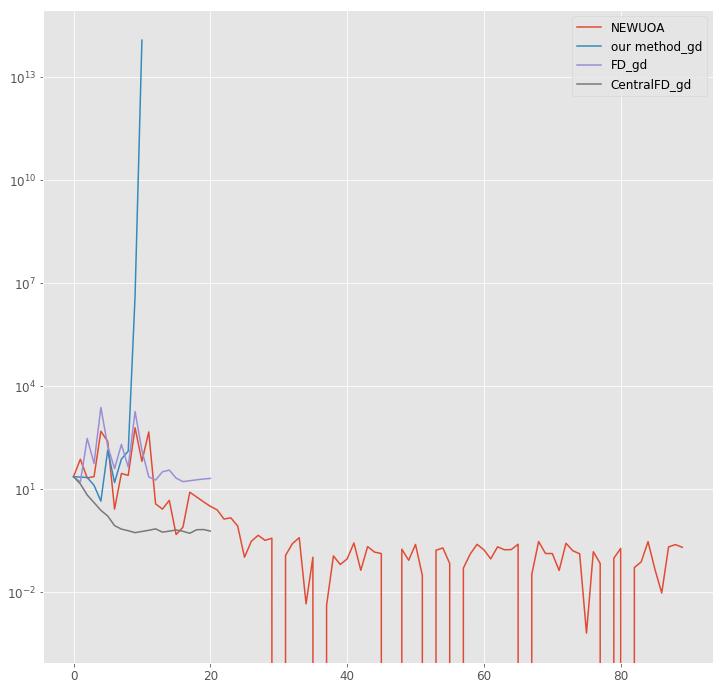

1
ALLINITU
FD central len 21
our len 21


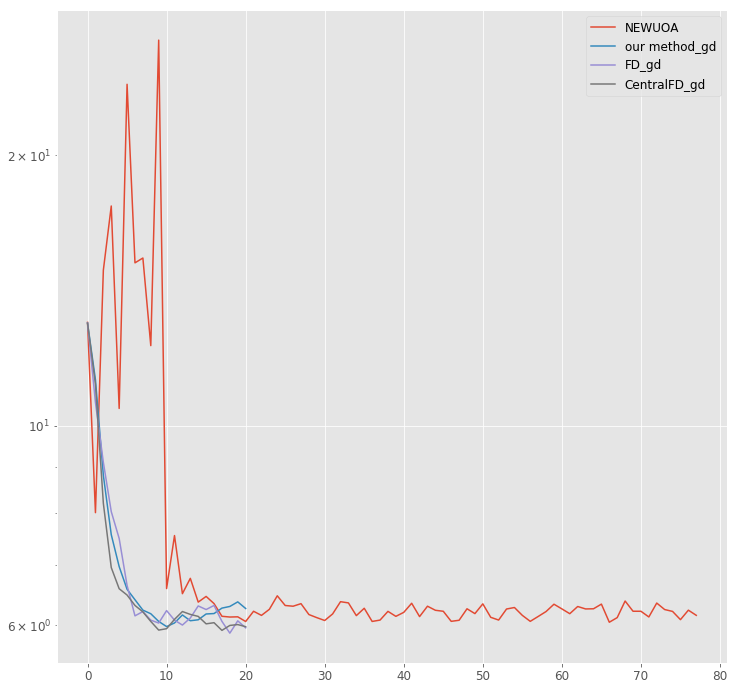

2
ARWHEAD
FD central len 21
our len 21


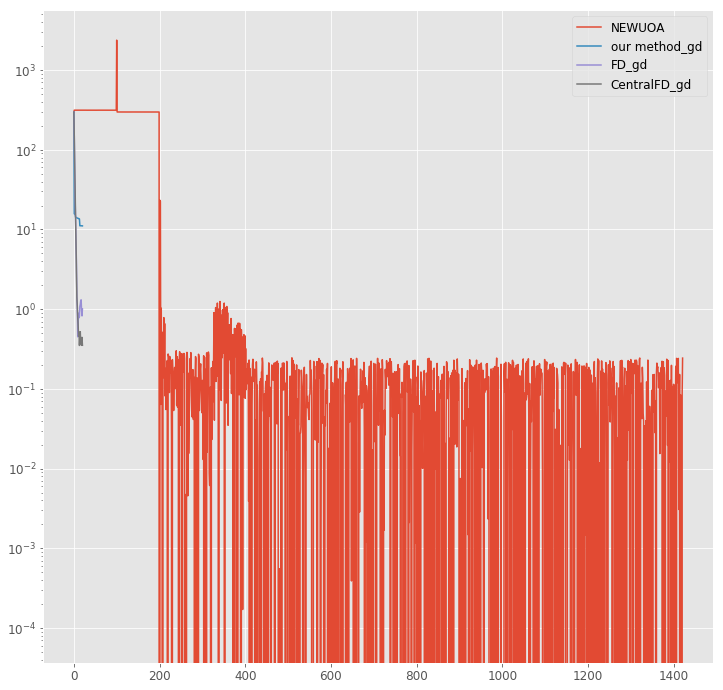

3
BARD
FD central len 21
our len 21


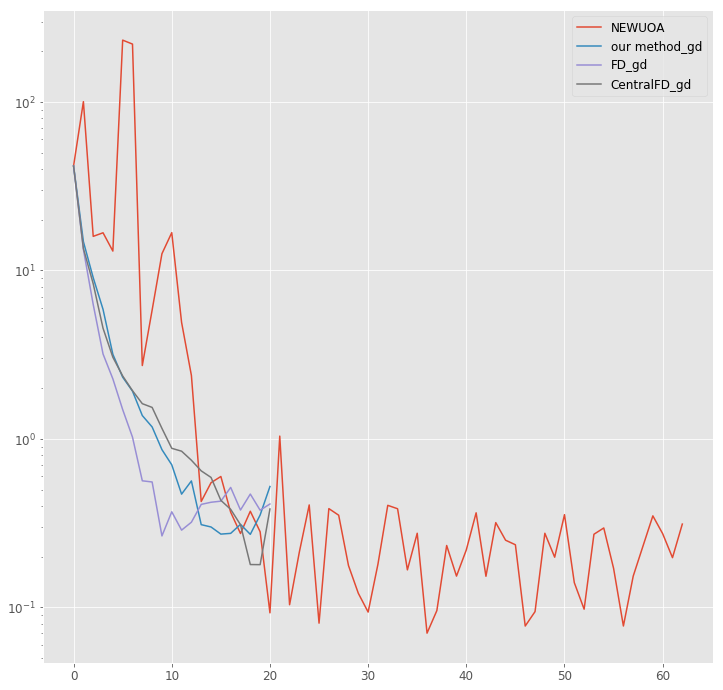

4
BDQRTIC
FD central len 21
our len 21


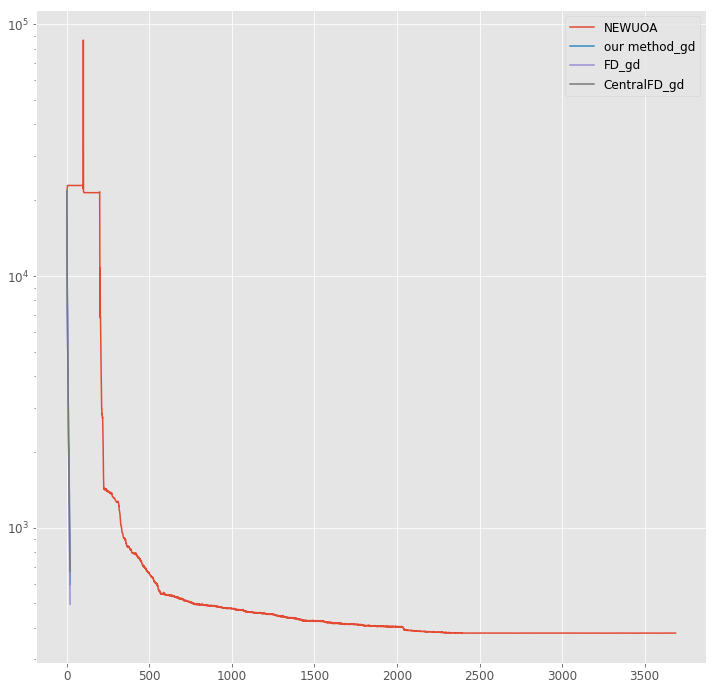

5
BIGGS3
FD central len 21
our len 21


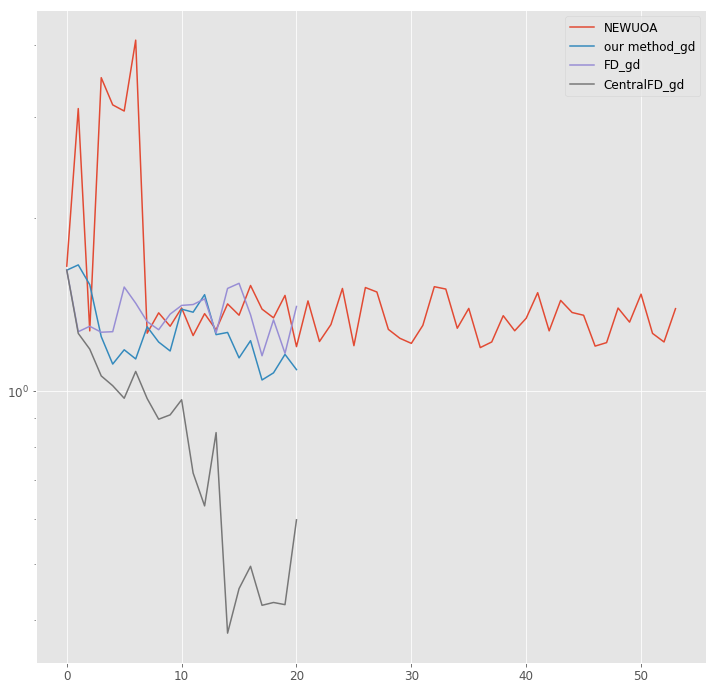

6
BIGGS5
FD central len 21
our len 21


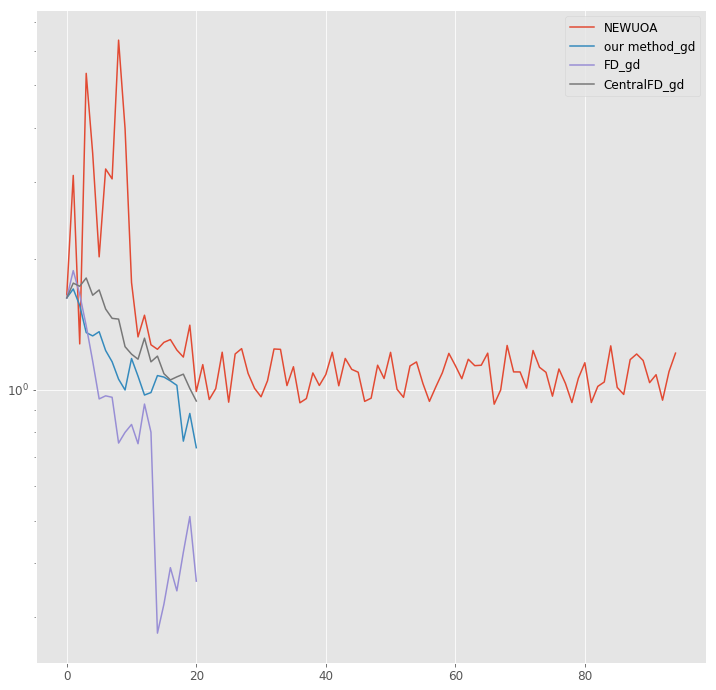

7
BIGGS6
FD central len 21
our len 21


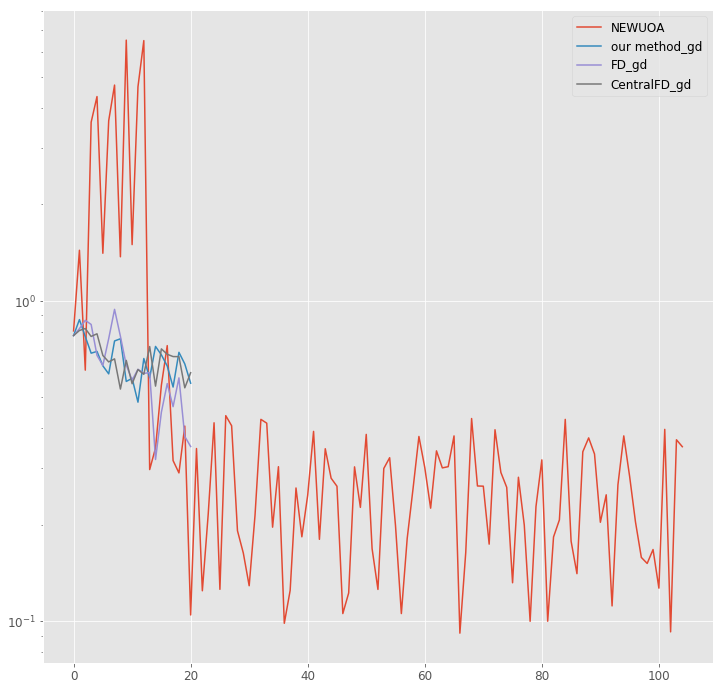

8
BOX2
FD central len 21
our len 21


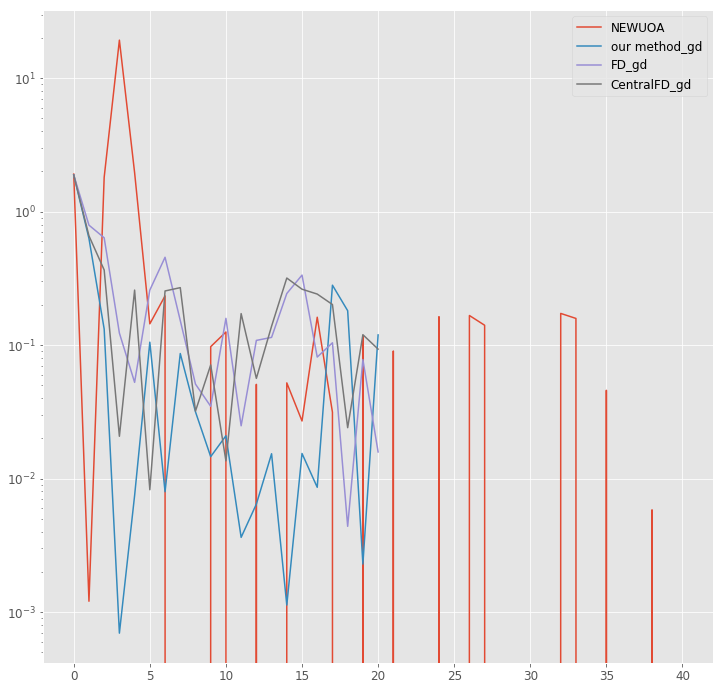

9
BOX3
FD central len 21
our len 21


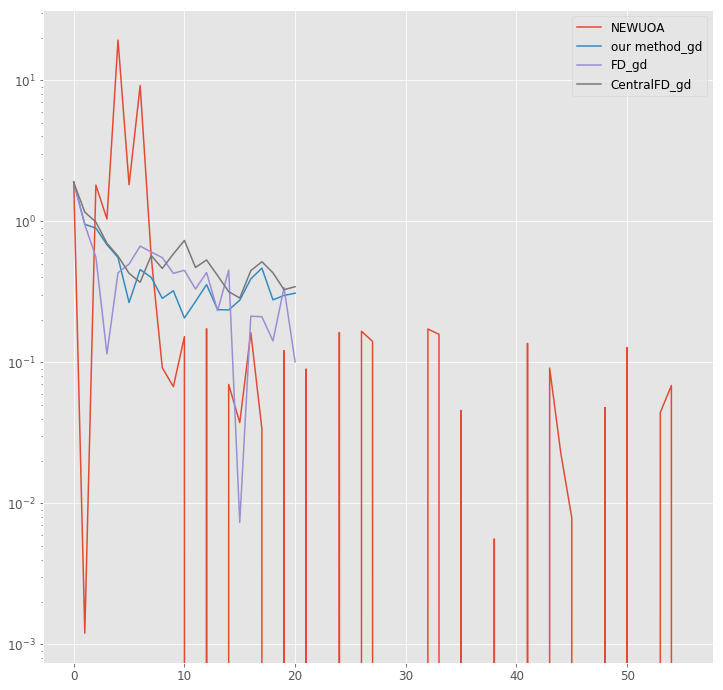

10
BRKMCC
FD central len 21
our len 21


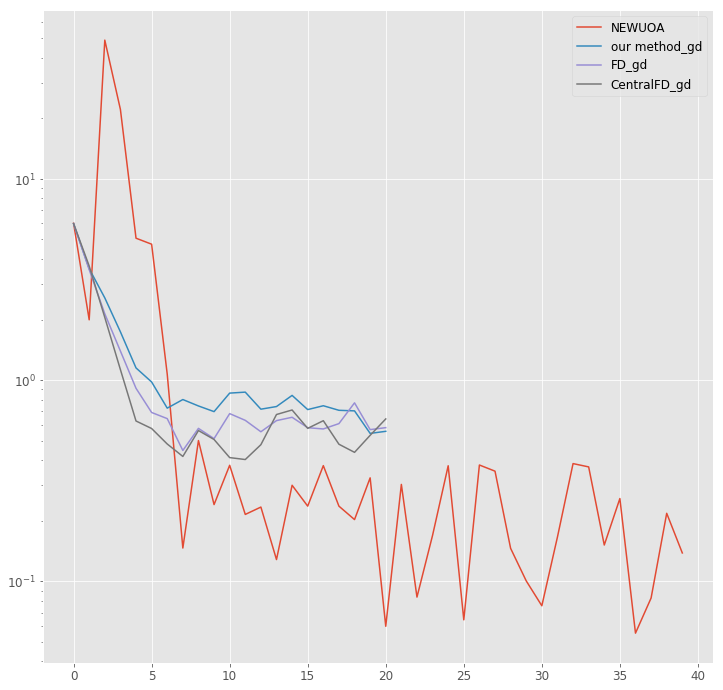

11
BROWNAL
FD central len 21
our len 21


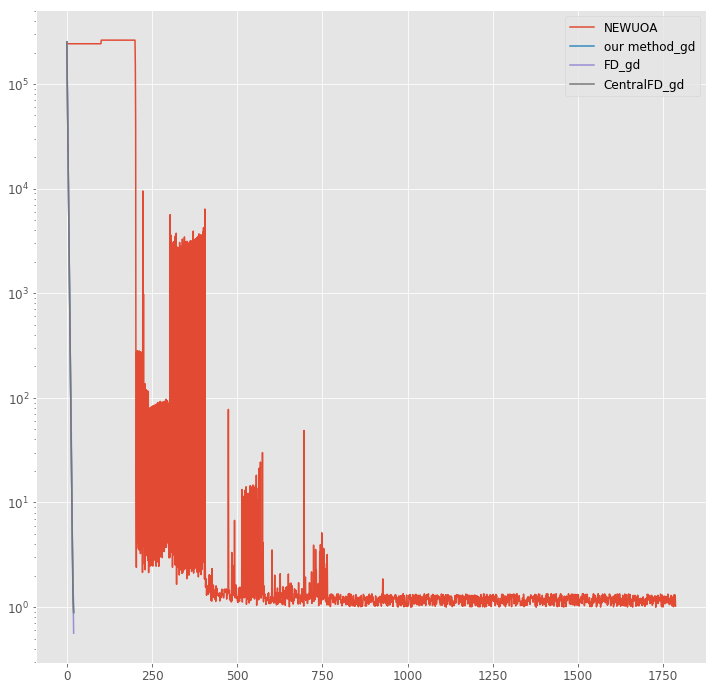

12
BROWNDEN
FD central len 4
our len 4


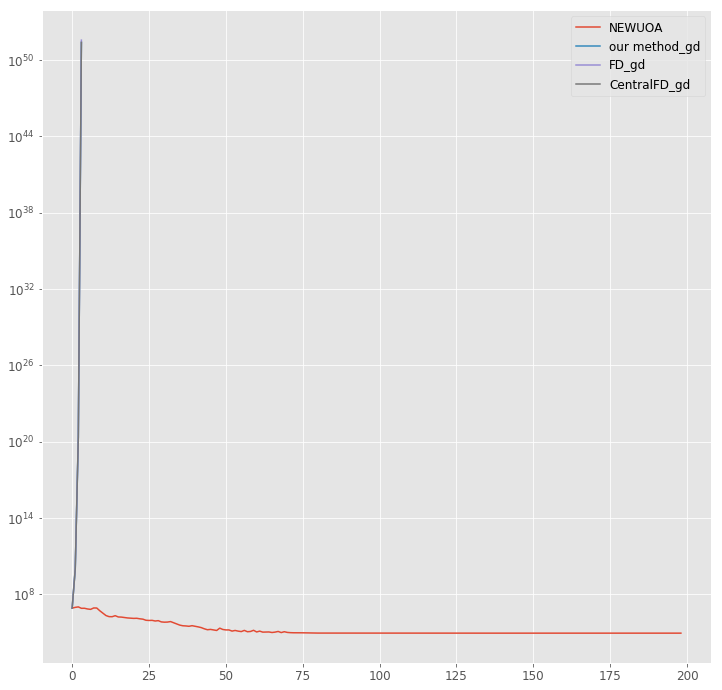

13
CLIFF
FD central len 21
our len 21


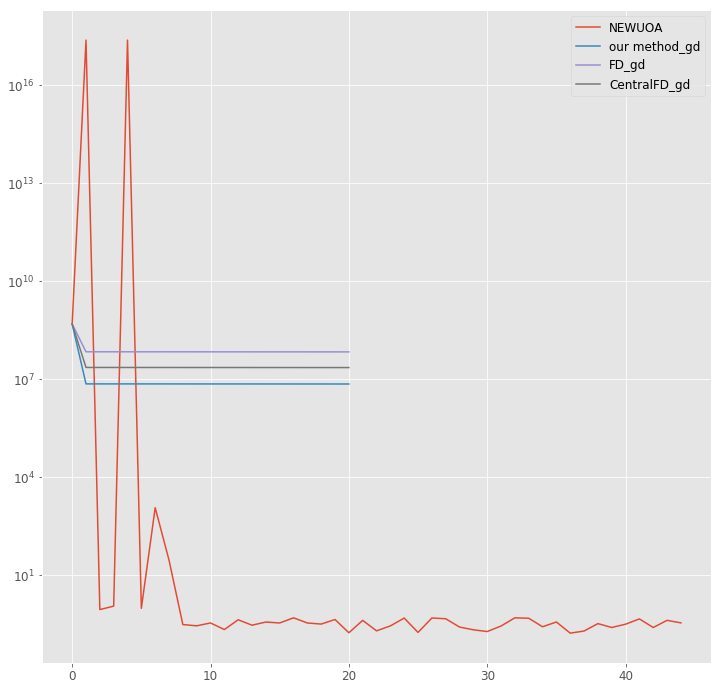

14
CRAGGLVY
Not found results for CRAGGLVY.
15
CUBE
FD central len 21
our len 21


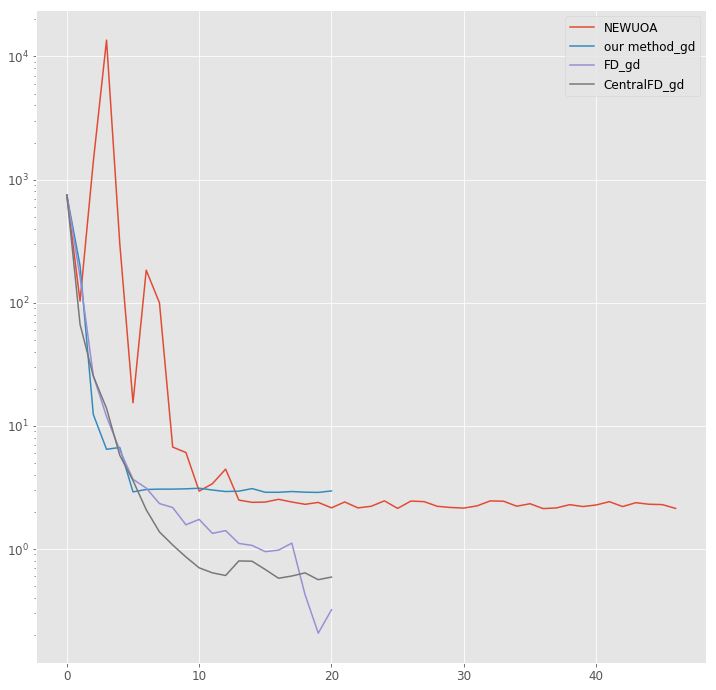

16
DENSCHND
FD central len 3
our len 2


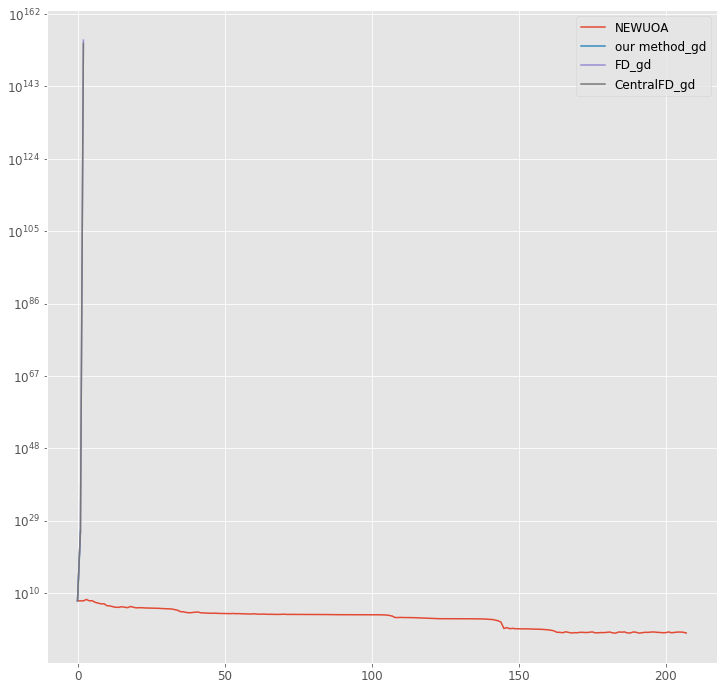

17
DENSCHNE
FD central len 21
our len 21


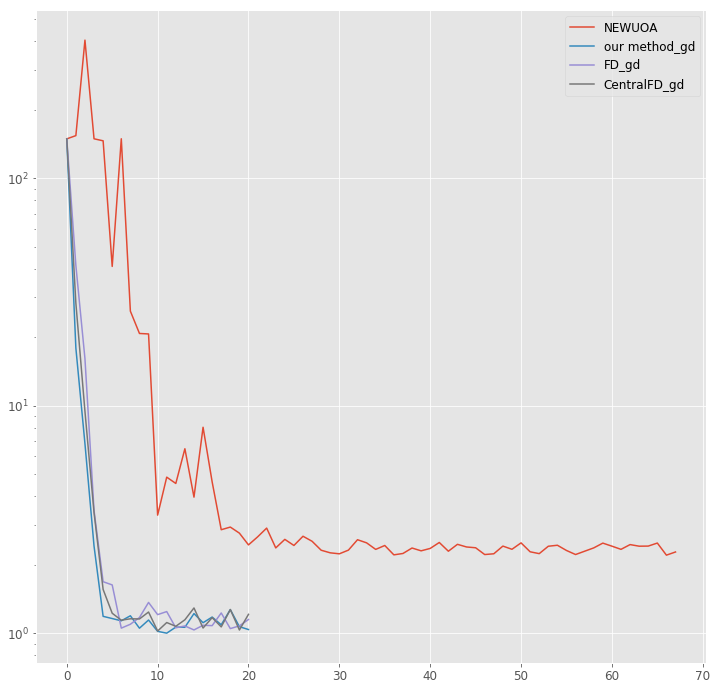

18
DIXMAANH
Not found results for DIXMAANH.
19
DQRTIC
FD central len 21
our len 21


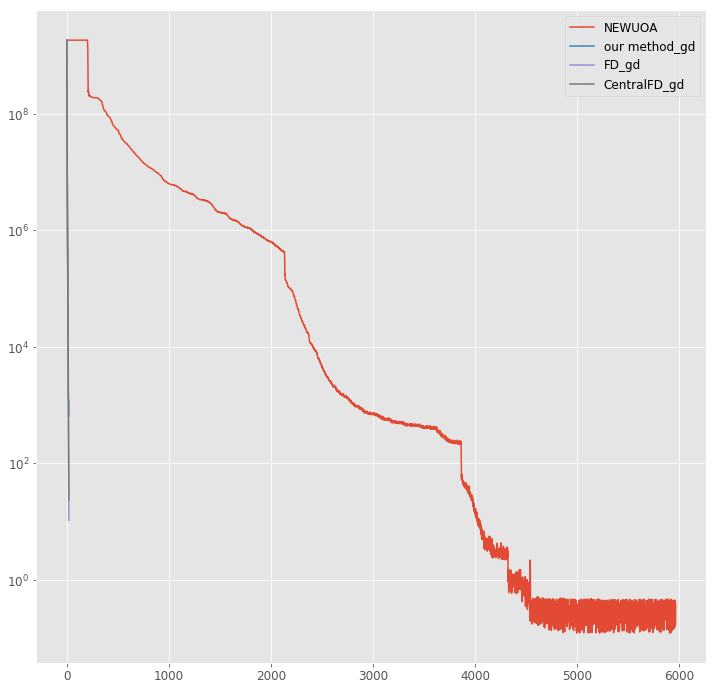

20
EDENSCH
FD central len 21
our len 21


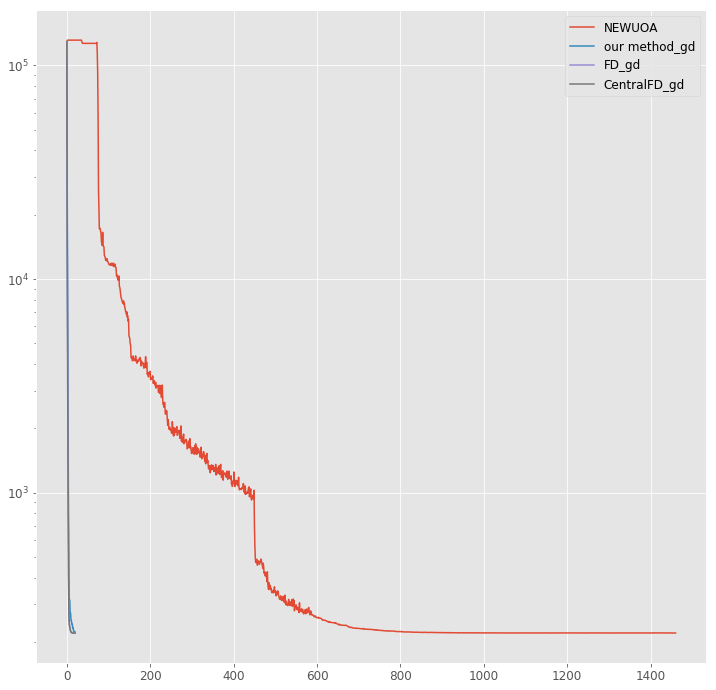

21
EIGENALS
Not found results for EIGENALS.
22
EIGENBLS
Not found results for EIGENBLS.
23
EIGENCLS
Not found results for EIGENCLS.
24
ENGVAL1
FD central len 21
our len 21


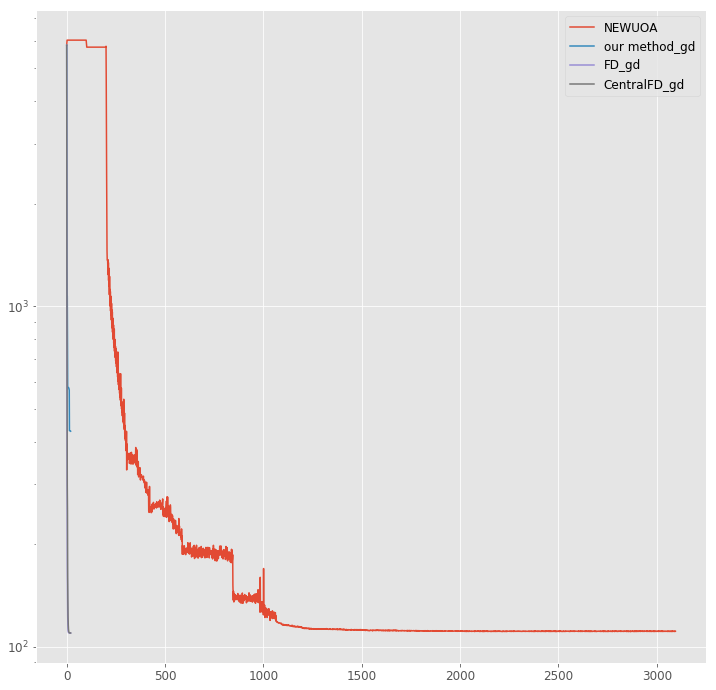

25
EXPFIT
FD central len 21
our len 21


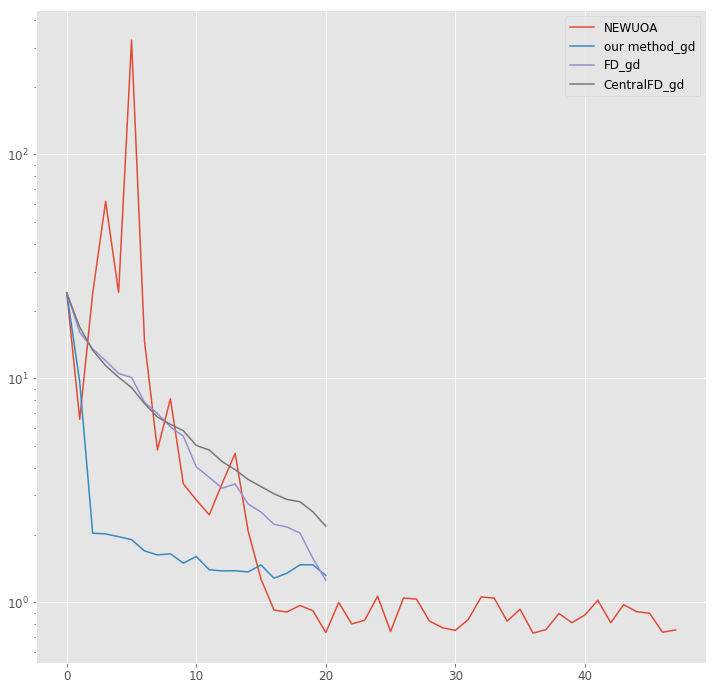

26
FLETCBV3
FD central len 21
our len 21


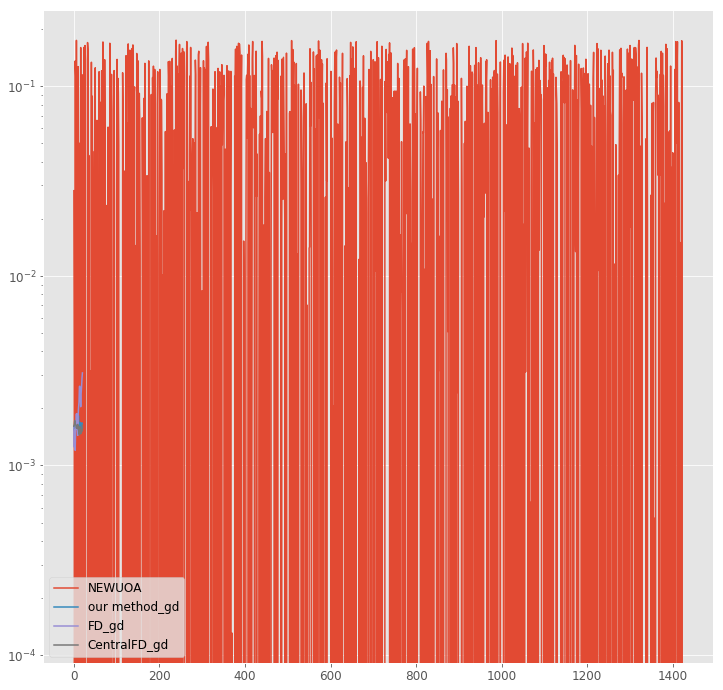

27
FLETCHBV
FD central len 21
our len 21


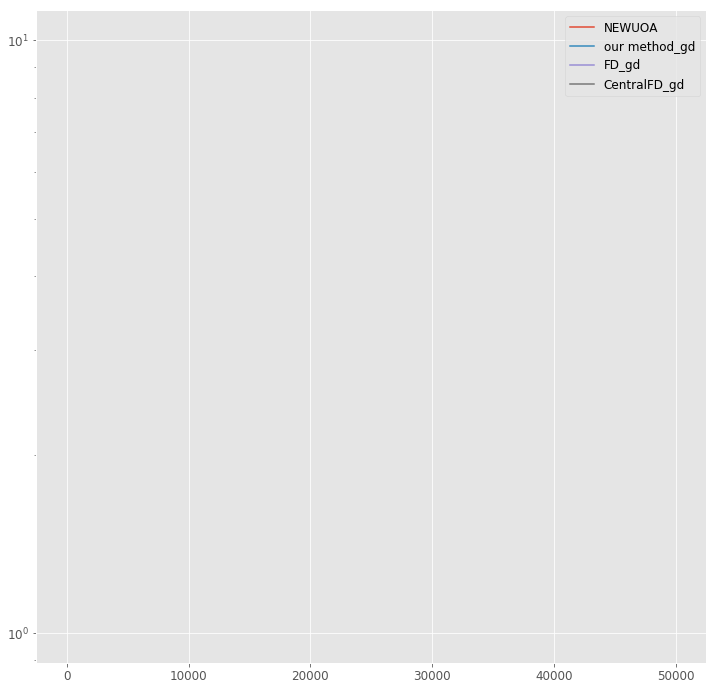

28
FREUROTH
FD central len 21
our len 21


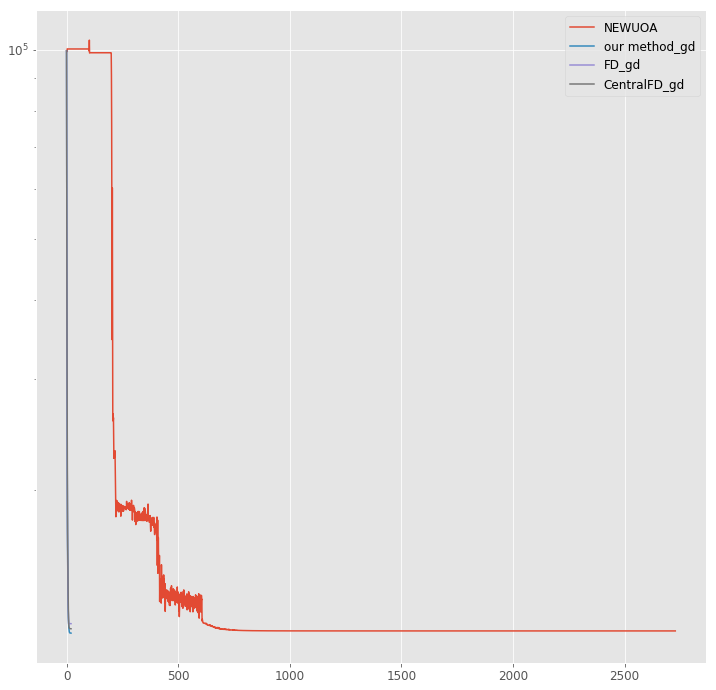

29
GENROSE
FD central len 21
our len 21


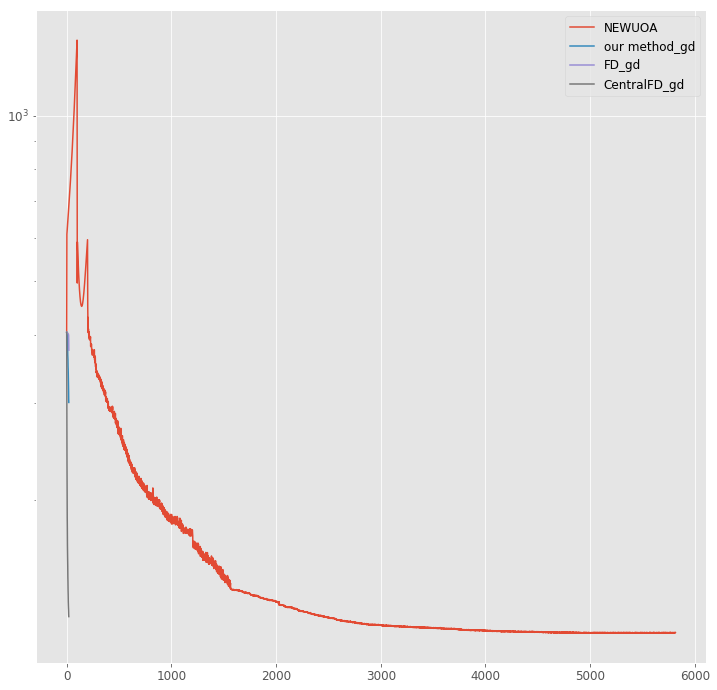

30
GULF
FD central len 21
our len 21


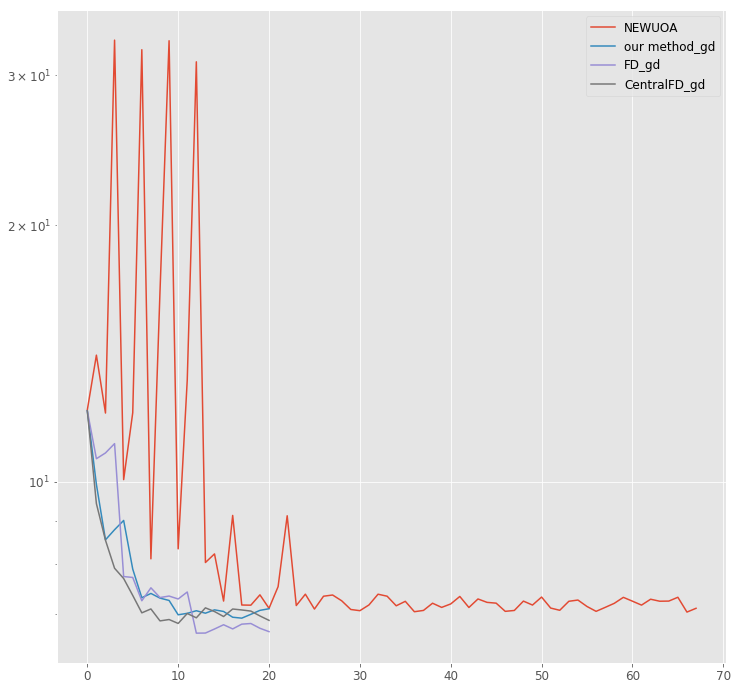

31
HAIRY
FD central len 21
our len 21


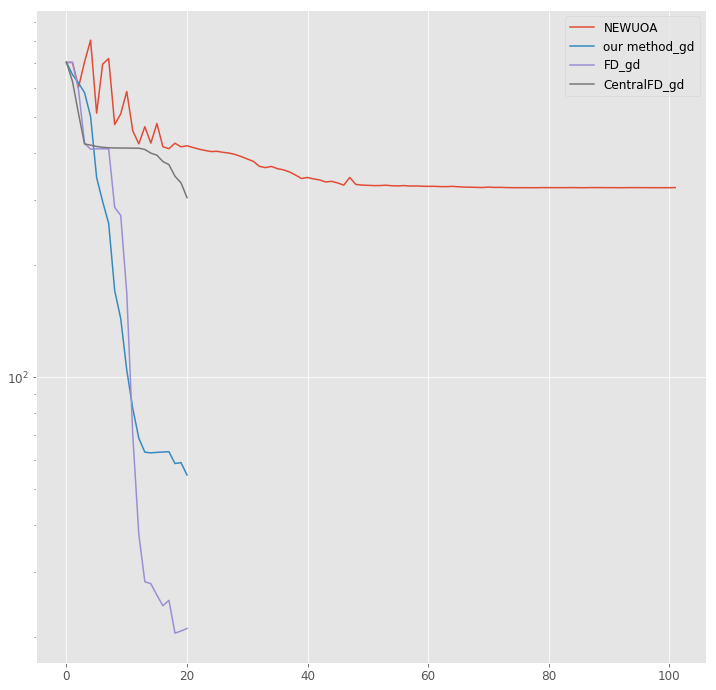

32
HELIX
FD central len 21
Not found results for HELIX.
33
NCB20B
FD central len 21
Not found results for NCB20B.
34
NONDIA
FD central len 21
Not found results for NONDIA.
35
NONDQUAR
FD central len 21
Not found results for NONDQUAR.
36
OSBORNEA
FD central len 21
Not found results for OSBORNEA.
37
OSBORNEB
FD central len 21
Not found results for OSBORNEB.
38
PENALTY1
FD central len 3
Not found results for PENALTY1.
39
PFIT1LS
FD central len 21
Not found results for PFIT1LS.
40
PFIT2LS
FD central len 21
Not found results for PFIT2LS.
41
PFIT3LS
FD central len 21
Not found results for PFIT3LS.
42
PFIT4LS
FD central len 21
Not found results for PFIT4LS.
43
QUARTC
FD central len 21
Not found results for QUARTC.
44
SINEVAL
FD central len 21
Not found results for SINEVAL.
45
SINQUAD
FD central len 21
Not found results for SINQUAD.
46
SISSER
FD central len 21
Not found results for SISSER.
47
SPARSQUR
FD central len 21
Not found results for SPARSQUR.
48
TOINTGSS
FD central len 21
Not found res

In [58]:
# eps = 0.1
noise_type = "uniform"
c1 = 0.1
c2 = 0.9
seed = 0
sig = 0.1


for i in range(len(adapt_functions)):
    test_problem_name = adapt_functions[i]

    try: 
        print(i)
        print(test_problem_name)
#         our_method = load_opt("OurMethod", test_problem_name, sig, noise_type, c1, c2, seed)
# #         adapt_fd = load_opt("AdaptFD", test_problem_name, sig, noise_type, c1, c2, seed)
        newuoa = load_opt("NEWUOA", test_problem_name, sig, noise_type, c1, c2, seed)
# #         newton_method = load_opt("NewtonExact", test_problem_name, sig, noise_type, c1, c2, seed)
#         fd = load_opt("FD", test_problem_name, sig, noise_type, c1, c2, seed)
#         central_fd = load_opt("CentralFD", test_problem_name, sig, noise_type, c1, c2, seed)

        our_method_gd = load_opt("OurMethod_GD", test_problem_name, sig, noise_type, c1, c2, seed)
        fd_gd = load_opt("FD_GD", test_problem_name, sig, noise_type, c1, c2, seed)
        central_fd_gd = load_opt("CentralFD_GD", test_problem_name, sig, noise_type, c1, c2, seed)



#         plt.plot(our_method[:, 2], our_method[:, 0], label="our method")
# #         plt.plot(adapt_fd[:, 2], adapt_fd[:, 0], label="AdaptFD")
#         plt.plot(newuoa, label="NEWUOA")
# #         plt.plot(newton_method[:, 2], newton_method[:, 0], label="NewtonExact")
#         plt.plot(fd[:, 2], fd[:, 0], label="FD")
#         plt.plot(central_fd[:, 2], central_fd[:, 0], label="CentralFD")

        print("FD central len", central_fd_gd.shape[0])
        print("our len", our_method_gd.shape[0])


        plt.plot(newuoa, label="NEWUOA")


        plt.plot(range(len(our_method_gd[:, 2])), our_method_gd[:, 0], label="our method_gd")
        plt.plot(range(len(fd_gd[:, 2])), fd_gd[:, 0], label="FD_gd")
        plt.plot(range(len(central_fd_gd[:, 2])), central_fd_gd[:, 0], label="CentralFD_gd")

#         plt.plot(our_method_gd[:, 2], our_method_gd[:, -1], label="our method_gd")
#         plt.plot(fd_gd[:, 2], fd_gd[:, -1], label="FD_gd")
#         plt.plot(central_fd_gd[:, 2], central_fd_gd[:, -1], label="CentralFD_gd")

        plt.yscale("log")
        plt.legend()
        plt.show()

    

    except:
        print("Not found results for {}.".format(test_problem_name))
    